Topic:  IMDB Film Yorumlarının Duygu Analizi için Farklı Sinir                       Ağlarının Performans Analizi

In [2]:

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Conv1D

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords


# Exploratory Data Analysis (EDA)

### Veri Setinden Okuma

In [4]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")

Veri setinde herhangi bir null değer var mı kontrol edildi.
Veri setindeki satır ve sütun sayıları yansıtıldı


In [5]:
display(movie_reviews.isnull().values.any())

display(movie_reviews.shape)


False

(50000, 2)

### Veri Seti Özeti

Dataset genel görüntüsü

In [6]:
display(movie_reviews.head());

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Veri setindeki olumlu ve olumsuz film yorumlarının dağılımı

<AxesSubplot:xlabel='sentiment', ylabel='count'>

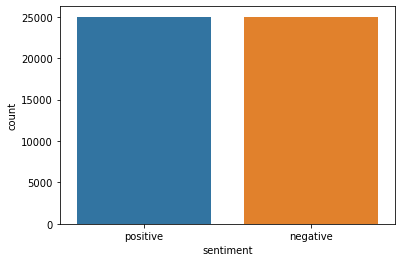

In [7]:
sns.countplot(x='sentiment', data=movie_reviews)

# Veri Ön İşleme¶

Text verisindeki;
HTML etiketleri,
Noktalama ve rakamlar,
Tekli karakterler silindi.

Oluşan çift boşluklar tek boşluklarla değiştirildi

Veri stinde bulunan örnek text aşağıda verilmiştir.

In [8]:
display(movie_reviews["review"][3])   

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

Veri temizleme ve ham veri oluşturma işlemi sonucunda örnek textin 
yeni görüntüsü aşağıda verilmiştir.

In [9]:
TAG_RE = re.compile(r'<[^>]+>')

def preprocess_text(sen):
    sentence = TAG_RE.sub('', sen)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen)) 
display(X[3])    

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

Hedef sütunundaki metinsel sınıflandırma sayısallaştırıldı
(positive -> 1,
negative -> 0)

In [10]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

display(y)


array([1, 1, 1, ..., 0, 0, 0])

Veriler eğitim seti için %80 ve test seti için %20 olarak ayrıldı.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Gömme Katmanını Hazırlama

Metinsel veriler, her bir kelimenin "one hot vektöre" dönüştürülmesi ve  anlamına göre vektör uzayında konumlandırılmasıyla sayısallaştırılmış oldu.
Sinir ağ yapılarına girdi olarak cümleleri temsil eden vektör listelerinden GloVe modeli ile oluşturulmuş öznitelik matriksi verildi.

Tokenizer sınıfı ile "word-to-index " sözlüğü oluşturuldu. Yapıdaki her bir kelime bir anahtar olarak kabul edildi ve 
her anahtara eşsiz bir index atandı.

In [12]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
display("X_train: ")
print(X_train[0])
print(X_train[1])
print(X_train[2])
print("X_train contains "+str(len(X_train))+ " list");

'X_train: '

[9, 43, 786, 2121, 524, 299, 1, 104, 1860, 1989, 4281, 2, 782, 4786, 9, 1, 224, 1, 77, 763, 51, 49, 17, 97, 3, 1, 24, 1968, 98, 31, 23, 32, 116, 1101, 9, 6, 5, 2323, 1163, 4, 449, 43, 540, 4, 88, 28, 20, 37, 892, 397, 13, 1, 154, 4, 2935, 22, 4318, 18, 2897, 9, 42, 71, 218, 69, 123, 7, 76, 3100, 193, 18, 232, 2, 1, 427, 198, 4888, 147, 19, 60, 24, 13, 70, 358, 299, 16, 15, 6, 198, 25, 302, 9, 11, 1, 1820, 112, 413, 2, 11, 1, 1651, 562, 67, 419, 373, 82, 114, 43, 110, 361, 28, 33, 15, 41, 10, 88, 441, 13, 357, 1145, 59, 7, 1, 460, 214, 992, 4, 4124, 7, 174, 3, 32, 433, 680, 607, 9, 66, 227, 233, 107, 830, 33, 169, 27, 217, 9, 1, 423, 360, 53, 3696, 273, 157, 1672, 187, 5, 1, 711, 1904, 1, 1177, 3, 2838, 3672, 1652, 2, 144, 147, 225, 3, 203, 320, 2, 147, 1052, 14, 85, 3, 131, 2790, 15, 152, 95, 3, 1, 3974, 299, 8, 12, 975, 33, 1, 485, 2567, 242, 66, 72, 104, 104, 678, 57, 80, 66, 148, 1331, 4, 223, 131, 20, 4319, 29, 137, 205, 1123, 11, 4341, 29, 2276, 2, 7, 8, 5, 438, 11, 610, 3, 1, 703

Yukarıda görüldüğü gibi Eğitim seti 40000 liste içeriyor yani 40000 cümle içermektedir. 
Ancak her bir listenin uzunluğu farklıdır çünkü her bir cümlenin uzunluğu farklılıdır. Bu durmda cümle uzunluklarını sabitlemek gerekmektedir.
X_test ve X_train'deki cümle uzunluklarının dağılımı gözlemlendi ve bu dağılıma göre cümle uzunluğunun sabitleneceği değer belirlendi.

C:\Users\begon\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\begon\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Train mean:  198.422675
Train median:  150.0
Train mode:  ModeResult(mode=array([117]), count=array([333]))


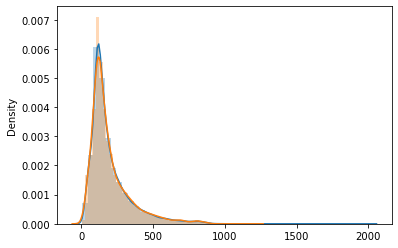

In [13]:
lng_train=[]
lng_test=[]
for i in X_train:
    lng_train.append(len(i))
for ii in X_test:
        lng_test.append(len(ii))
sns.distplot(lng_train, hist_kws={"alpha":0.3})
sns.distplot(lng_test, hist_kws={"alpha":0.3})
print("Train mean: ", np.mean(lng_train))
print("Train median: ", np.median(lng_train))
print("Train mode: ", stats.mode(lng_train))

Yukarıdaki dağılıma göre çoğu yorumun 117 kelimeden oluştuğu gözlemlenmiştir.
Bu durumda sabitlecek cümle uzunluğu en yakın 120 seçilmesi planlanmıştır. Ancak kullanılması planlanan GloVe modeli 100 boyutlu bir vektör modeli olduğu için  ve dağılım sonucunun (117) 100'e yakın bir değer olduğundan oluşabilecek sapmanın göz ardı edilebilecek düzeyde olduğu kararlaştırıldı ve sabitlenecek değer 100 seçildi. 
100den az olan vektörleri 100 olacak şekilde 0'la dolduruldu("PADDING"); 
100den çok olan vektörleri ise küçültüldü. ("TRUNCATION")


In [14]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
print("Birbirinden farklı "+ str(vocab_size)+" kelime vardır")

Birbirinden farklı 92547 kelime vardır


Öznitelik matriksini oluşturmak için GloVe Modeli kullanıldı. 
Sonrasınnda keylerden ve her bir keyin karşılık geldiği gömülü listeden oluşan 
bir sözlük yaratıldı.

In [55]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
display(embedding_matrix)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37771001,  0.22946   , -0.30311   , ..., -0.33610001,
         0.02637   , -0.72302002],
       [ 0.99882001,  0.044     ,  0.58508003, ..., -0.54869002,
         0.15141   ,  1.36880004]])

Son olarak, her satır numarasının cümlelerdeki kelimelerin indexine karşılık geldiği bir gömme matrisi oluşturulmuştur. Matrisin 100 sütunu vardır ve her sütunda o indexe sahip kelimenin 100 boyutlu GloVe kelime gömme değeri vardır.

# MLP ile Sınıflandırma

In [65]:
model_mlp = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_mlp.add(embedding_layer)

model_mlp.add(Flatten())
model_mlp.add(Dense(1, activation='sigmoid'))

model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model_mlp.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 100)          9254700   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


MLP mimarisinin eğitimi ve alınan skor aşağıda verilmiştir.

In [66]:
history_mlp = model_mlp.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score_test = model_mlp.evaluate(X_test, y_test, verbose=1)
score_train = model_mlp.evaluate(X_train, y_train, verbose=1)
print("Test Score:", score_test[0])
print("Test Accuracy:", score_test[1])
print("Train Score:", score_train[0])
print("Train Accuracy:", score_train[1])

Epoch 1/6
250/250 [==============================] - 1s 5ms/step - loss: 0.6024 - acc: 0.6730 - val_loss: 0.5454 - val_acc: 0.7232
Epoch 2/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4958 - acc: 0.7607 - val_loss: 0.5178 - val_acc: 0.7435
Epoch 3/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4564 - acc: 0.7865 - val_loss: 0.5333 - val_acc: 0.7366
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4394 - acc: 0.7986 - val_loss: 0.5491 - val_acc: 0.7255
Epoch 5/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4240 - acc: 0.8065 - val_loss: 0.5295 - val_acc: 0.7454
Epoch 6/6
1250/1250 [==============================] - 2s 2ms/step - loss: 0.4064 - acc: 0.8192
Test Score: 0.5415753126144409
Test Accuracy: 0.7434999942779541
Train Score: 0.406355082988739
Train Accuracy: 0.8192499876022339


Test Accuracy yaklaşık %74 çıkarken Train Accuracy yaklaşıl %82 çıkmıştır. 
Bu durum modelin overfit olduğunu,veriyi ezberlediğini, göstermektedir.
İdealde train ve test setindeki accuracy farkının minimum olması beklenmektedir.

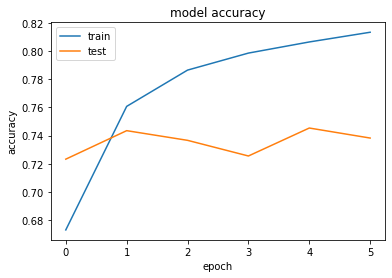

In [67]:
plt.plot(history_mlp.history['acc'])
plt.plot(history_mlp.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

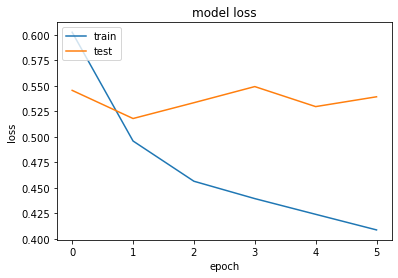

In [68]:
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

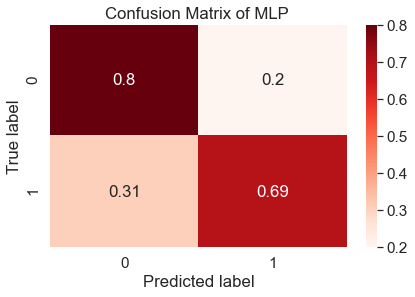

In [94]:

y_pred=model_mlp.predict_classes(X_test)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
classes=[0,1]
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
sns.set(font_scale=1.4)
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Reds)
plt.tight_layout()
plt.title("Confusion Matrix of MLP ")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# CNN ile Sınıflandırma

Evrişimli sinir ağı, çoğunlukla 2 boyutlu veri sınıflandırmasnda (görüntü sınıflandırılmasında) kullanılan bir ağ türüdür.Sinir ağının ilk katmanında, görüntüdeki ayırt edici öznitelikler bulunmaya çalışılır. Sonraki katmanlarında ise başlangıçta algılanan öznitelikler daha büyük ve ayırt edici öznitelikler oluşturmak için birleştirilir. Son olarak belirlenen öznitelikler üzerinden girdinin skoru belirlenir ve sınıflandırılma gerçekleştirilir.

2 boyutlu verilerde, öznitelik tespiti için kullanılan evrişimli sinir ağlarının 1 boyutlu metin verilerinin ayırt edici özelliklerinin belirlenmesinde de iyi çalıştığı literatür tarmasında gözlendi. Bunun üzerine 1 evrişim katmanlı ve 1 havuz katmanlı basit bir evrişimsel sinir ağı oluşturuldu.

In [72]:
model_cnn = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_cnn.add(embedding_layer)

model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model_cnn.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 100)          9254700   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None


Yukarıda görüldüğü üzere 128 öznitelikten oluşan tek boyutlu bir evrişim katmanı oluşturuldu ve kullanılan etkinleştirme fonksiyonu sigmoid olarak belirlendi. Ardından, öznitelik boyutunu küçültmek için global bir maksimum havuzlama katmanı eklendi.

In [73]:
history_cnn = model_cnn.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score_test = model_cnn.evaluate(X_test, y_test, verbose=1)
score_train = model_cnn.evaluate(X_train, y_train, verbose=1)
print("Test Score:", score_test[0])
print("Test Accuracy:", score_test[1])
print("Train Score:", score_train[0])
print("Train Accuracy:", score_train[1])

Epoch 1/6
250/250 [==============================] - 7s 29ms/step - loss: 0.5084 - acc: 0.7477 - val_loss: 0.4021 - val_acc: 0.8179
Epoch 2/6
250/250 [==============================] - 7s 28ms/step - loss: 0.3716 - acc: 0.8362 - val_loss: 0.3651 - val_acc: 0.8378
Epoch 3/6
250/250 [==============================] - 7s 29ms/step - loss: 0.3214 - acc: 0.8634 - val_loss: 0.3781 - val_acc: 0.8279
Epoch 4/6
250/250 [==============================] - 7s 28ms/step - loss: 0.2845 - acc: 0.8836 - val_loss: 0.3596 - val_acc: 0.8384
Epoch 5/6
250/250 [==============================] - 7s 29ms/step - loss: 0.2532 - acc: 0.9001 - val_loss: 0.3549 - val_acc: 0.8411
Epoch 6/6
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2103 - acc: 0.9276
Test Score: 0.3400014638900757
Test Accuracy: 0.8482999801635742
Train Score: 0.21028217673301697
Train Accuracy: 0.9276000261306763


CNN modeli ile MLP modeli arasındaki eğitim ve test doğruluğu karşılaştırıldığında;
CNN modelinde eğitim doğruluğunun yaklaşık %93 olduğu, MLP modelinde eğitim doğruluğunun ise yaklaşık %82 olduğu gözlemlenir.
Bunun yanında CNN modelindeki test doğruluğunun yaklaşık %85 olduğu, MLP modelindeki test doğruluğunun ise %74 olduğu gözlemlenir. 
Yukarıdaki bilgiler sonucunda CNN modelinin MLP modeline kıyasla metinsel sınıflandırmada daha iyi performans gösterdiği gözlemlenmiştir. Ancak CNN modelinde de ortaya çıkan eğitim ve test doğruluğu arasındaki büyük fark, modelin veriyi ezberlediğini (overfitting) ortaya koymuştur.

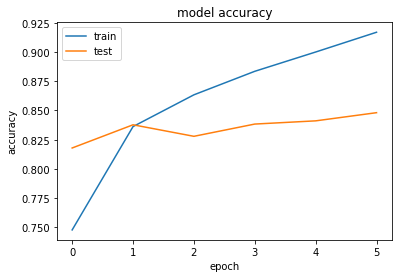

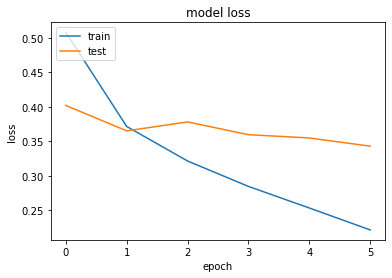

In [74]:
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

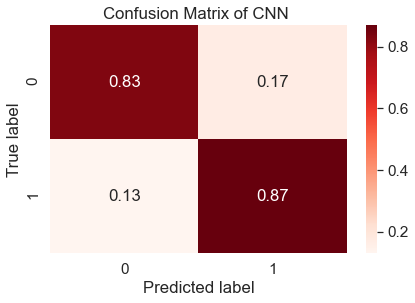

In [95]:

y_pred=model_cnn.predict_classes(X_test)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
classes=[0,1]
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
sns.set(font_scale=1.4)
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Reds)
plt.tight_layout()
plt.title("Confusion Matrix of CNN ")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Tekrarlayan Sinir Ağı (LSTM) ile Metin Sınıflandırma

Literatür taraması sırasında sıralı verilerde sınıflandırma perfonsı yüksek olan ağlardan birinin Tekrarlayan Sinir Ağı (RNN) olduğu belirlenmiştir. Metin verilerinin de sıralı veriler olduğu düşüldüğünde, Film yorumlarının duygusal sınıflandırlmasında da RNN sinir ağının iyi bir peformans sergileyeceği tahmin edilmiştir. 

In [75]:
model_lstm = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model_lstm.add(embedding_layer)
model_lstm.add(LSTM(128))

model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model_lstm.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 100)          9254700   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [76]:
history = model_lstm.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
score_test = model_lstm.evaluate(X_test, y_test, verbose=1)
score_train = model_lstm.evaluate(X_train, y_train, verbose=1)
print("Test Score:", score_test[0])
print("Test Accuracy:", score_test[1])
print("Train Score:", score_train[0])
print("Train Accuracy:", score_train[1])

Epoch 1/6
250/250 [==============================] - 30s 119ms/step - loss: 0.5442 - acc: 0.7157 - val_loss: 0.4503 - val_acc: 0.7868
Epoch 2/6
250/250 [==============================] - 30s 121ms/step - loss: 0.4449 - acc: 0.7952 - val_loss: 0.4141 - val_acc: 0.8145
Epoch 3/6
250/250 [==============================] - 30s 120ms/step - loss: 0.3999 - acc: 0.8184 - val_loss: 0.3981 - val_acc: 0.8166
Epoch 4/6
250/250 [==============================] - 31s 124ms/step - loss: 0.3646 - acc: 0.8389 - val_loss: 0.3731 - val_acc: 0.8309
Epoch 5/6
250/250 [==============================] - 31s 122ms/step - loss: 0.3408 - acc: 0.8492 - val_loss: 0.3420 - val_acc: 0.8497
Epoch 6/6
1250/1250 [==============================] - 26s 21ms/step - loss: 0.3157 - acc: 0.8665
Test Score: 0.3406710624694824
Test Accuracy: 0.8492000102996826
Train Score: 0.3157050907611847
Train Accuracy: 0.866474986076355


LSTM modelinin test doğruluğunun CNN modelinde olduğu gibi yaklaşık %85 lduğu ve eğitim modelinin doğruluğunun ise yaklaşık%87 olduğu gözlemlenmişitr. Bu durum LSTM modelinde eğitim ve test doğruluğunun arasındaki farkın küçük olduğunu ve bu modelin diğer iki modelin aksine veriyi ezberlemediğini gösterniştir.


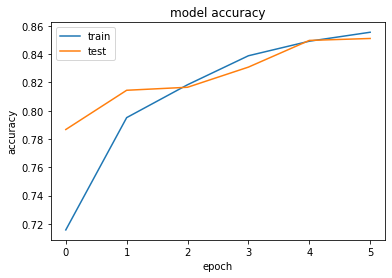

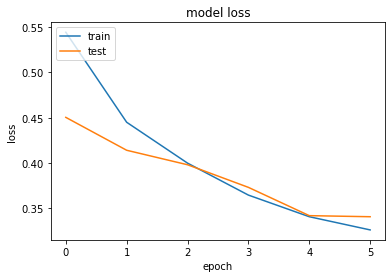

In [77]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

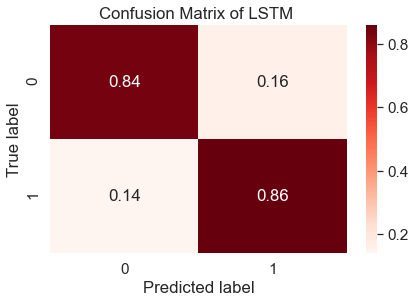

In [97]:
y_pred=model_lstm.predict_classes(X_test)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
classes=[0,1]
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
sns.set(font_scale=1.4)
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Reds)
plt.tight_layout()
plt.title("Confusion Matrix of LSTM ")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Yukarıdaki grafiklerde de görüldüğü üzere LSTM modelinde eğitim ve test setleri arasındaki doğruluk farkının, basit sinir ağı ve CNN ile karşılaştırıldığında çok daha küçüktür. Benzer şekilde, kayıp değerleri arasındaki fark da ihmal edilebilir düzeydedir, bu da LSTM modelinin veriyi ezberlemediğini göstermektedir. 
Metinsel Film yorumlarının duygusal analizi için kullanılacak en iyi sınıflandırma modelinin RNN sinir ağının bir çesşidi olan LSTM modeli olduğu sonucuna varılmıştır.